<a href="https://colab.research.google.com/github/dasjyotishka/Semantic-Segmentation-of-residential-properties-and-assets-after-Hurricane-Harvey/blob/main/Hurricane_Harvey_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hurricane Harvey Segmentation Challenge

##Importing required libraries

In [ ]:
"""
Created on Fri Jan 13 12:23:05 2023

@author: Jyotishka Das and Hao Xu
"""



'''In the first section we are defining some modules that would be used in the execution phase'''


from tqdm import tqdm
import os
import cv2
import numpy as np
from random import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from PIL import Image, ImageOps
from os import listdir , path
from os.path import isfile, join
from pathlib import Path
import torch
import torchvision
from torchvision import transforms as T
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import imageio
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
import time
import pandas as pd
import matplotlib.pyplot as plt
import os









##Pre-processing of the images

The training images downloaded from the competition website are stored in folder called ***train_images***, and the corresponding masks are stored in a folder called train_masks. Two blank folders are also created in the same directory called test_images. Now, for every item in ***train_images***, we are checking whether its corresponding mask exits in ***train_mask***. If it does not exist, we move the image from ***train_images*** folder to the *test_images* folder.

In [ ]:
# Connect to google drive where we store the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if gpu is connected
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 22 15:50:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
IMG_SIZE = 320


train_img_dir='/content/drive/MyDrive/FDL/Final_Submission/train_images'
train_mask_dir='/content/drive/MyDrive/FDL/Final_Submission/train_masks'
test_img_dir='/content/drive/MyDrive/FDL/Final_Submission/test_images'
validation_img_dir='/content/drive/MyDrive/FDL/Final_Submission/val_images'
validation_mask_dir='/content/drive/MyDrive/FDL/Final_Submission/val_masks'

files_train_img_dir = [f for f in listdir(train_img_dir) if isfile(join(train_img_dir, f))]
files_train_mask_dir = [f for f in listdir(train_mask_dir) if isfile(join(train_mask_dir, f))]
files_test_img_dir = [f for f in listdir(test_img_dir) if isfile(join(test_img_dir, f))]
files_validation_img_dir = [f for f in listdir(validation_img_dir) if isfile(join(test_img_dir, f))]
files_validation_mask_dir = [f for f in listdir(validation_mask_dir) if isfile(join(test_img_dir, f))]

transform_mask_resize = T.Resize((IMG_SIZE,IMG_SIZE), interpolation=Image.NEAREST)
transform_toTensor = T.ToTensor()


train_dataloader=[]
val_dataloader=[]


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
#Function to split the dataset into train and test datasets.
def create_train_test_split ():


    common_files = []
    flag=0
    for i in files_train_img_dir:
        for j in files_train_mask_dir:
            if(path.splitext(i)[0] == path.splitext(j)[0]): #this compares it name by name.
                flag=1
                common_files.append(i)
        if (flag==0):
            Path(train_img_dir+"/"+path.splitext(i)[0]+".tif").rename(test_img_dir+"/"+path.splitext(i)[0]+".tif")
        flag=0
    return 0


create_train_test_split()

0

Now, the ***train_images*** folder would contain 299 images and the ***test_images*** folder would contain 75 images. For training the model, we would need to further split the training dataset into train and validation dataset. So, we move 15% of the images (45 random images) and their corresponding masks from the training folders to the validation folders. Now, at this stage, the ***train_images*** and ***train_masks*** folders would contain 254 images, and the ***validation_images*** and ***validation_masks*** folders would contain 45 images. Create blank folders where the tensors would be stored and store the corresponding tensors in those folders. Iterate through all masks and images in train set, resize them, transform them into tensors and store them in the new folder

In [ ]:
# Specify paths to your files (glob glob stores paths to all files in a folder in a list)

train_img_link_list  = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/train_images/*'))
train_mask_link_list = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/train_masks/*'))
test_img_link_list   = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/test_images/*'))
validation_img_link_list = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/val_images/*'))
validation_mask_link_list = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/val_masks/*'))

In [ ]:
import torch
import torchvision
from torchvision import transforms

#Function to convert the images to tensors
def convert_tensor ():

  val_img_list=[]
  val_img_list = [str(x) for x in val_img_list]

  # Transformation pipeline
  transform_img = transforms.Compose([
      transforms.Resize([IMG_SIZE,IMG_SIZE]),
      transforms.ToTensor()
  ])

  transform_mask = transforms.Compose([
      transforms.Resize([IMG_SIZE,IMG_SIZE], interpolation=Image.NEAREST),
      transforms.ToTensor()
  ])

  transform_mask_prova = transforms.Compose([
      transforms.ToTensor()
  ])

  # Iterate through all masks and images in train set, transform them and store corresponging tensors in a new folder
  for i in tqdm(range(len(train_img_link_list))):

      img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
      mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
      assert img_id == mask_id    # Make sure id's match

      img   = Image.open(train_img_link_list[i])
      mask  = Image.open(train_mask_link_list[i])

      img  = transform_img(img)
      mask = transform_mask(mask)*255
      mask = mask.int()

      torch.save(img,"/content/drive/MyDrive/FDL/Final_Submission/train_images_"+str(IMG_SIZE)+"/"+img_id+".pt")
      torch.save(mask, "/content/drive/MyDrive/FDL/Final_Submission/train_masks_"+str(IMG_SIZE)+"/"+mask_id+".pt")


  # Iterate through all masks and images in validation set, transform them and store corresponging tensors in a new folder
  for i in tqdm(range(len(validation_img_link_list))):

      img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
      mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
      assert img_id == mask_id    # Make sure id's match

      img   = Image.open(train_img_link_list[i])
      mask  = Image.open(train_mask_link_list[i])

      img  = transform_img(img)
      mask = transform_mask(mask)*255
      mask = mask.int()

      torch.save(img,"/content/drive/MyDrive/FDL/Final_Submission/val_images_"+str(IMG_SIZE)+"/"+img_id+".pt")
      torch.save(mask, "/content/drive/MyDrive/FDL/Final_Submission/val_masks_"+str(IMG_SIZE)+"/"+mask_id+".pt")

  print('Train and Validation sets created')

  # Iterate through all images in test set, transform them and store corresponging tensors in a new folder
  for i in tqdm(range(len(test_img_link_list))):

      img_id  = test_img_link_list[i].split('/')[-1].split('.')[0]

      img   = Image.open(test_img_link_list[i])
      img   = transform_img(img)

      torch.save(img,"/content/drive/MyDrive/FDL/Final_Submission/test_images_"+str(IMG_SIZE)+"/"+img_id+".pt")


  print('Test set created')




convert_tensor()

100%|██████████| 45/45 [00:14<00:00,  3.07it/s]


Train and Validation sets created


100%|██████████| 75/75 [00:20<00:00,  3.64it/s]

Test set created


##Build a custom Dataloader

We load the image and the mask tensors. We then convert the grayscale mask tensors from the dimension [1, H, W] to [H, W] because the loss function accepts images in the form [B, H, W], where **B** is the batch-size, **H** is the height and **W** is the width of the images. After that, an ad-hoc transformation on the images are performed to improve the segmentation accuracy. If the images are too bright or too dark, then we scale its brightness.


In [ ]:
BATCH_SIZE=10

'''A class for Dataset is created'''

class tensorDataset(Dataset):


    def __init__(self, images:list, masks:list, train:bool):
        self.image_links = images
        self.mask_links  = masks
        self.train = train


    def __getitem__(self, index):

        # Select the link to the specific image
        img_id  = self.image_links[index]
        mask_id = self.mask_links[index]

        # Loading the image tensors
        img  = torch.load(img_id)
        mask = torch.load(mask_id)


        # Convert the grayscale  mask tensors from the dimension [1, H, W] to [H, W] because the loss function accepts images in the form [B, H, W]
        mask = mask.squeeze(0)

        # Gradient is turned on for the image
        img = img.detach().clone().requires_grad_(True)
        mask = mask.long()

        return img, mask


    def __len__(self):
        return len(self.image_links)


    def transform(self, img, mask):

        # If the images are too bright or too dark, scale its brightness
        temp_rand = np.random.rand()
        if temp_rand < 0.3:
            t_darken_image = T.ColorJitter(brightness=[0.6, 0.8])
            img = t_darken_image(img)

        elif temp_rand > 0.7:
            t_brighten_image = T.ColorJitter(brightness=[1.2, 1.4])
            img = t_brighten_image(img)

        return img, mask

In [ ]:
'''The train, test and validation datasets are created through DataLoaders'''

list_train_img  = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/train_images_320/*'))
list_train_mask = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/train_masks_320/*'))
list_val_img    = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/val_images_320/*'))
list_val_mask   = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/val_masks_320/*'))



train_dataset = tensorDataset(list_train_img, list_train_mask, train=True)
val_dataset   = tensorDataset(list_val_img, list_val_mask, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)



##Calculation of Dice-Score

The Dice score is used to calculate the accuracy of our segmentation.
The Dice Coefficient is 2 x (the Area of Overlap divided by the total number of pixels in the test and the predicted masks).

In [ ]:
#A function to calculation the Dice scores of the segmented images.

def calculate_dice_score(preds, true_mask):

    f1_batch = []

    for i in range(len(preds)):
        f1_image = []
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)

        # The shape of the image tensor is changed from the dimension [26, H, W] to [H, W]
        img = torch.argmax(img, dim=0)

        for label in range(26):
            if torch.sum(mask == label) != 0:
                area_of_intersect = torch.sum((img == label) * (mask == label))
                area_of_img       = torch.sum(img == label)
                area_of_label     = torch.sum(mask == label)
                f1 = 2*area_of_intersect / (area_of_img + area_of_label)
                f1_image.append(f1)

        f1_batch.append(np.mean([tensor.cpu() for tensor in f1_image]))
    return np.mean(f1_batch)





In [ ]:
# Accuracy
def accuracy(preds, true_mask):
    '''
    preds should be [B, 25, H, W]
    true_mask should be [B, H, W]
    '''
    accuracy_batch = []

    for i in range(len(preds)):
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)

        # Change shape of img from [25, H, W] to [H, W]
        img  = torch.argmax(img, dim=0)

        accuracy_batch.append(torch.sum(img == mask).item() / (IMG_SIZE*IMG_SIZE))  # FIX LATER

    return np.mean(accuracy_batch)

##Training the model

In [ ]:
'''A function to train the model. If at any step the f1_score obtained is greater than 0.3, the model
is saved in a directory folder.'''
def train():

  min_val_f1 = 0.3

  for epoch in range(1, Epochs):

      # Define evaluation metrics
      model.train()
      train_losses   = []
      train_accuracy = []
      train_f1       = []

      for i, batch in enumerate(train_dataloader):

          '''Extract the data and the corresponding masks.
          A batch of B color images of the size 512x512 are stored in a 4D-tensor of shape
          [B,3,H,W], while a batch of B grayscale masks of the size 512x512 are
          in the shape [B,H,W]'''
          img_batch, mask_batch = batch
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          '''Train the model.'''
          optimizer.zero_grad()

          '''The output masks should be one-hot encoded
          for every 26 output classes and would have a shape of [B, 26, H, W].
          This is because the loss function only takes input in this format.
          Ref: https://www.jeremyjordan.me/semantic-segmentation/'''
          output = model(img_batch)
          loss   = criterion(output, mask_batch)
          loss.backward()
          optimizer.step()

          #After 1 epoch, add the loss to the list list
          f1 = calculate_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          train_losses.append(loss.item())
          train_accuracy.append(acc)
          train_f1.append(f1)


      # Update the global metrics
      print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}')
      total_train_losses.append(np.mean(train_losses))
      total_train_accuracy.append(np.mean(train_accuracy))
      total_train_f1.append(np.mean(train_f1))


      # Define the validate metrics
      model.eval()
      val_losses   = []
      val_accuracy = []
      val_f1       = []

      for i, batch in enumerate(val_dataloader):
          #Extract the images and the corresponding masks
          img_batch, mask_batch = batch
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Validate model
          with torch.cuda.amp.autocast():
            output = model(img_batch)
            loss   = criterion(output, mask_batch)

           #After 1 epoch, add the loss to the list list
          f1 = calculate_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          val_losses.append(loss.item())
          val_accuracy.append(acc)
          val_f1.append(f1)



      # Print the updated global metrics
      print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
      print('---------------------------------------------------------------------------------')
      total_val_losses.append(np.mean(val_losses))
      total_val_accuracy.append(np.mean(val_accuracy))
      total_val_f1.append(np.mean(val_f1))


      # Save the model
      if np.mean(val_f1) > min_val_f1:
        torch.save(model.state_dict(), "/content/drive/MyDrive/FDL/Final_Submission/models/RESNET101-ImageNet-DeepLabV3/DeepNet_res101_SI320_EP"+str(epoch)+"_LR001.pt")
        min_val_f1 = np.mean(val_f1)

      # Save the results so far
      temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
      temp_df.to_csv('train_val_measures')

We have used a DeepLabv3+ architecture to train our semantic segmentation model. The DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding a simple yet effective decoder module to cachieve an encoder-decoder structure. The encoder module processes multiscale contextual information by applying dilated convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.cA resnet101 architecture was found to be the best encoder for the current segmentation challenge,and it has been pretrained on the imagenet dataset.

In [ ]:
# Initialization of the model and the hyperparameters.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



model = smp.DeepLabV3Plus(
     encoder_name = 'resnet101',
     encoder_weights = 'imagenet',
     classes = 27,
     activation = None,
 ).to(DEVICE)



total_train_losses   = []
total_val_losses     = []
total_train_accuracy = []
total_val_accuracy   = []
total_train_f1       = []
total_val_f1         = []

In [ ]:
# Data preparation Hyperparameters
Epochs = 50
LR = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss().to(DEVICE)

train()

TRAIN       Epoch: 1 | Epoch metrics | loss: 1.2518, f1: 0.320, accuracy: 0.708
VALIDATION  Epoch: 1 | Epoch metrics | loss: 1.1164, f1: 0.328, accuracy: 0.744
---------------------------------------------------------------------------------
TRAIN       Epoch: 2 | Epoch metrics | loss: 1.0473, f1: 0.355, accuracy: 0.741
VALIDATION  Epoch: 2 | Epoch metrics | loss: 0.9066, f1: 0.346, accuracy: 0.770
---------------------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 0.9101, f1: 0.378, accuracy: 0.767
VALIDATION  Epoch: 3 | Epoch metrics | loss: 0.8158, f1: 0.353, accuracy: 0.784
---------------------------------------------------------------------------------
TRAIN       Epoch: 4 | Epoch metrics | loss: 0.7951, f1: 0.395, accuracy: 0.792
VALIDATION  Epoch: 4 | Epoch metrics | loss: 0.6990, f1: 0.373, accuracy: 0.814
---------------------------------------------------------------------------------
TRAIN       Epoch: 5 | Epoch met

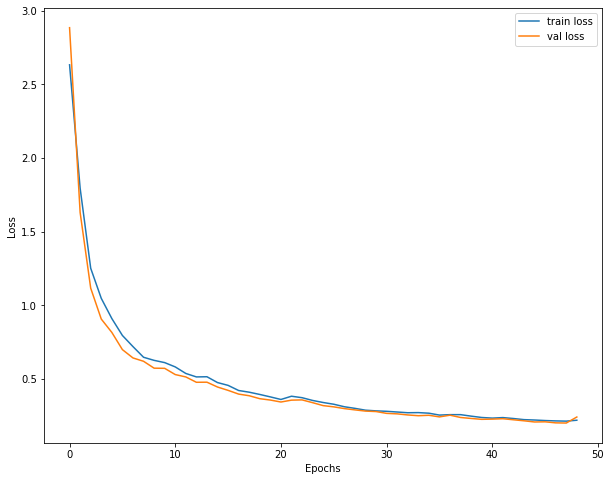

In [ ]:
#Plot the train-loss and validation-loss graph
plt.figure(figsize=(10,8))
plt.plot(list(range(len(total_train_losses)+1))[:49], total_train_losses[:49])
plt.plot(list(range(len(total_train_losses)+1))[:49], total_val_losses[:49])
plt.legend(['train loss', 'val loss', 'val f1'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

##Prediction of masks for test images

Load the model for which we want to generate prediction masks and generate the masks. We selected the model saved at epoch 46 because it gave the highest validation accuracy (92.9%)

In [ ]:
model = smp.DeepLabV3Plus(
     encoder_name = 'resnet101',
     encoder_weights = 'imagenet',
     classes = 27,
     activation = None,
 )

model.load_state_dict(torch.load('/content/drive/MyDrive/FDL/Final_Submission/models/RESNET101-ImageNet-DeepLabV3/DeepNet_res101_SI320_EP26_LR001.pt'))

<All keys matched successfully>

Generate the prediction masks and resize the mask sizes to that of their corresponding image size before submission.

In [ ]:
'''Function to predict the masks of the test images'''
def predict_masks():
    test_img_link_list = sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/test_images_320/*'))
    torch_list = [torch.load(link) for link in test_img_link_list]
    model.eval()
    import tqdm
    # Calculate output for each image in test set and save the prediction in new test_preds folder
    for i in tqdm.tqdm(range(len(torch_list))):
      img_id = test_img_link_list[i].split('/')[-1].split('.')[0]
      img = torch_list[i].unsqueeze(0)
      output = model(img)
      output = torch.argmax(output, dim=1).squeeze(0)
      output = np.uint8(output)
      output = Image.fromarray(output)
      output.save("/content/drive/MyDrive/FDL/Final_Submission/test_preds/"+str(img_id)+".png")

predict_masks()



100%|██████████| 75/75 [00:55<00:00,  1.35it/s]


In [ ]:

'''The masks obtained are of the size 512x512. We need to resize the sizes masks to that of the corresponding images'''
def resize_images():
    directory_resize=sorted(glob.glob('/content/drive/MyDrive/FDL/Final_Submission/test_preds/*'))
    pred_names=[]
    for numbers in directory_resize:
      pred_names.append(numbers.split('/')[-1].split('.')[0])
    for name_img in tqdm(pred_names):
      raw = cv2.imread("/content/drive/MyDrive/FDL/Final_Submission/test_images/"+str(name_img)+".tif")
      shape = (raw.shape[1], raw.shape[0])
      image_read = cv2.imread("/content/drive/MyDrive/FDL/Final_Submission/test_preds/"+str(name_img)+".png", -1)
      image_read = cv2.resize(image_read, shape, interpolation = cv2.INTER_NEAREST)
      cv2.imwrite("/content/drive/MyDrive/FDL/Final_Submission/test_preds_resized/"+str(name_img)+".png", image_read)

resize_images()


100%|██████████| 75/75 [00:17<00:00,  4.26it/s]


In [ ]:
'''Submission of tar file'''
def submission():
    import tarfile

    tar = tarfile.open("DeepLabV3-Epoch-LR0001.tar", "w")

    for root, dir, files in os.walk('/content/drive/MyDrive/FDL/Final_Submission/test_preds_resized'):
        for  file in files:
            fullpath = os.path.join(root, file)
            tar.add(fullpath, arcname=file)

    tar.close()

submission()
